In [1]:
!python --version

Python 3.9.16


In [2]:
# Install dependencies
%pip install -q numerapi pandas lightgbm cloudpickle pyarrow scikit-learn scipy==1.10.1

Note: you may need to restart the kernel to use updated packages.


In [20]:
from numerapi import NumerAPI
import pandas as pd
import json
napi = NumerAPI()

# use one of the latest data versions
DATA_VERSION = "v4.3"

In [4]:
napi.download_dataset("v4.3/train_int8.parquet", "v4.3/train_int8.parquet")
napi.download_dataset("v4.3/validation_int8.parquet", "v4.3/validation_int8.parquet")
napi.download_dataset("v4.3/live_int8.parquet", "v4.3/live_int8.parquet")
napi.download_dataset("v4.3/live_example_preds.parquet", "v4.3/live_example_preds.parquet")
napi.download_dataset("v4.3/validation_example_preds.parquet", "v4.3/validation_example_preds.parquet")
napi.download_dataset("v4.3/features.json", "v4.3/features.json")
napi.download_dataset("v4.3/meta_model.parquet", "v4.3/meta_model.parquet")
napi.download_dataset("v4.3/live_benchmark_models.parquet", "v4.3/live_benchmark_models.parquet")
napi.download_dataset("v4.3/validation_benchmark_models.parquet", "v4.3/validation_benchmark_models.parquet")
napi.download_dataset("v4.3/train_benchmark_models.parquet", "v4.3/train_benchmark_models.parquet")

2024-02-17 20:43:49,230 INFO numerapi.utils: target file already exists
2024-02-17 20:43:49,237 INFO numerapi.utils: download complete
2024-02-17 20:43:50,556 INFO numerapi.utils: target file already exists
2024-02-17 20:43:50,556 INFO numerapi.utils: download complete
2024-02-17 20:43:51,787 INFO numerapi.utils: target file already exists
2024-02-17 20:43:51,787 INFO numerapi.utils: download complete
2024-02-17 20:43:53,030 INFO numerapi.utils: target file already exists
2024-02-17 20:43:53,030 INFO numerapi.utils: download complete
2024-02-17 20:43:54,304 INFO numerapi.utils: target file already exists
2024-02-17 20:43:54,304 INFO numerapi.utils: download complete
2024-02-17 20:43:55,439 INFO numerapi.utils: target file already exists
2024-02-17 20:43:55,439 INFO numerapi.utils: download complete
2024-02-17 20:43:56,754 INFO numerapi.utils: target file already exists
2024-02-17 20:43:56,755 INFO numerapi.utils: download complete
2024-02-17 20:43:57,947 INFO numerapi.utils: target fil

'v4.3/train_benchmark_models.parquet'

In [22]:
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]

sizes = ["small", "medium", "all"]
groups = [
  "intelligence",
  "wisdom",
  "charisma",
  "dexterity",
  "strength",
  "constitution",
  "agility",
  "serenity",
  "all"
]

# compile the intersections of feature sets and feature groups
subgroups = {}
for size in sizes:
    subgroups[size] = {}
    for group in groups:
        subgroups[size][group] = (
            set(feature_sets[size])
            .intersection(set(feature_sets[group]))
        )

# convert to data frame and display the feature count of each intersection
pd.DataFrame(subgroups).applymap(len).sort_values(by="all", ascending=False)

,small,medium,all
all,42,705,2376
constitution,2,134,335
charisma,3,116,290
agility,2,58,145
wisdom,3,56,140
strength,1,54,135
serenity,3,34,95
dexterity,4,21,51
intelligence,2,14,35


In [24]:
# define the features and intelligence features
features = feature_metadata["feature_sets"]["all"] # use "all" for better performance. Requires more RAM.
all_intelligence_feats = list(subgroups["all"]["intelligence"])

# load the training data
train = pd.read_parquet(f"{DATA_VERSION}/train_int8.parquet", columns=["era"]+features+["target"])
validation = pd.read_parquet(f"{DATA_VERSION}/validation_int8.parquet", columns=["era"]+features+["target"])
train = pd.concat([train, validation])
del validation

# Downsample to every 4th era to reduce memory usage and
# speedup model training (suggested for Colab free tier).
# train = train[train["era"].isin(train["era"].unique()[::4])]

# Full models

In [ ]:
import lightgbm as lgb

for group in groups:
    group_feats = list(subgroups["all"][group])

    model = lgb.LGBMRegressor(
    n_estimators=20000,  # If you want to use a larger model we've found 20_000 trees to be better
    learning_rate=0.001, # and a learning rate of 0.001
    max_depth=6, # and max_depth=6
    num_leaves=2**6-1, # and num_leaves of 2**6-1
    colsample_bytree=0.1
    )
    model.fit(
        train[group_feats],
        train["target"]
    )

    def predict(
        live_features: pd.DataFrame,
        live_benchmark_models: pd.DataFrame
    ) -> pd.DataFrame:
        live_predictions = model.predict(live_features[group_feats])
        submission = pd.Series(live_predictions, index=live_features.index)
        return submission.to_frame("prediction")

    # Pickle predict function
    import cloudpickle
    p = cloudpickle.dumps(predict)
    with open(f"models/{group}_full.pkl", "wb") as f:
        f.write(p)

In [10]:
# Train model
import lightgbm as lgb
model = lgb.LGBMRegressor(
    n_estimators=20000,  # If you want to use a larger model we've found 20_000 trees to be better
    learning_rate=0.001, # and a learning rate of 0.001
    max_depth=6, # and max_depth=6
    num_leaves=2**6-1, # and num_leaves of 2**6-1
    colsample_bytree=0.1
)
model.fit(
    train[all_intelligence_feats],
    train["target"]
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 2420521, number of used features: 35
[LightGBM] [Info] Start training from score 0.500015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMRegressor(colsample_bytree=0.1, learning_rate=0.001, max_depth=6,
              n_estimators=20000, num_leaves=63)

In [12]:
# Define predict function
def predict(
    live_features: pd.DataFrame,
    live_benchmark_models: pd.DataFrame
 ) -> pd.DataFrame:
    live_predictions = model.predict(live_features[all_intelligence_feats])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

# Pickle predict function
import cloudpickle
p = cloudpickle.dumps(predict)
with open("models/intelligence_full.pkl", "wb") as f:
    f.write(p)

In [13]:
# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet");

# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + all_intelligence_feats
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = model.predict(validation[all_intelligence_feats])
validation[["era", "prediction", "target"]]

2024-02-17 21:33:57,651 INFO numerapi.utils: target file already exists
2024-02-17 21:33:57,651 INFO numerapi.utils: download complete


,era,prediction,target
id,,,
n002a15bc5575bbb,0579,0.505128,0.25
n00309caaa0f955e,0579,0.499460,0.50
n00576b397182463,0579,0.496083,0.50
n00633405d59c6a1,0579,0.504681,1.00
n008c2eefc8911c7,0579,0.508073,0.50
...,...,...,...
nffbac0ca31b666c,1095,0.497430,0.50
nffbd52f4a0973ef,1095,0.494974,0.50
nffd25d0a9b2e914,1095,0.515836,0.75


In [14]:
# import the 2 scoring functions
from numerai_tools.scoring import numerai_corr, correlation_contribution

# Download and join in the meta_model for the validation eras
napi.download_dataset(f"{DATA_VERSION}/meta_model.parquet")
validation["meta_model"] = pd.read_parquet(
    f"{DATA_VERSION}/meta_model.parquet"
)["numerai_meta_model"]

2024-02-17 21:40:09,368 INFO numerapi.utils: target file already exists
2024-02-17 21:40:09,369 INFO numerapi.utils: download complete


<Axes: title={'center': 'Validation MMC'}, xlabel='era'>

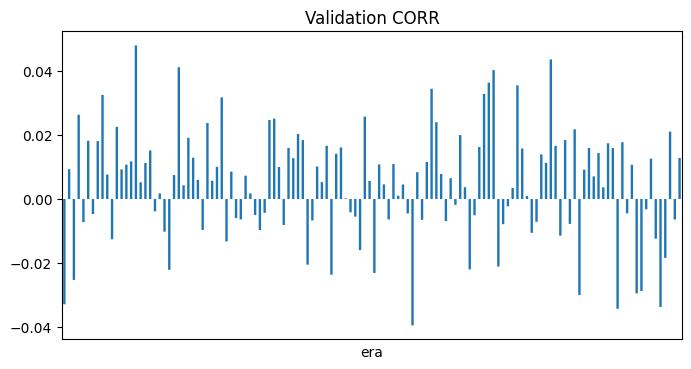

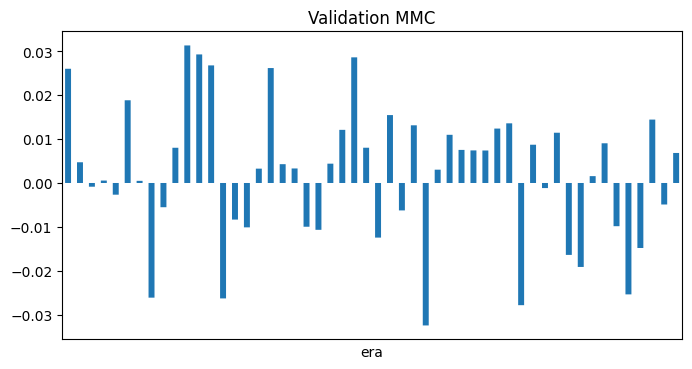

In [15]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

<Axes: title={'center': 'Cumulative Validation MMC'}, xlabel='era'>

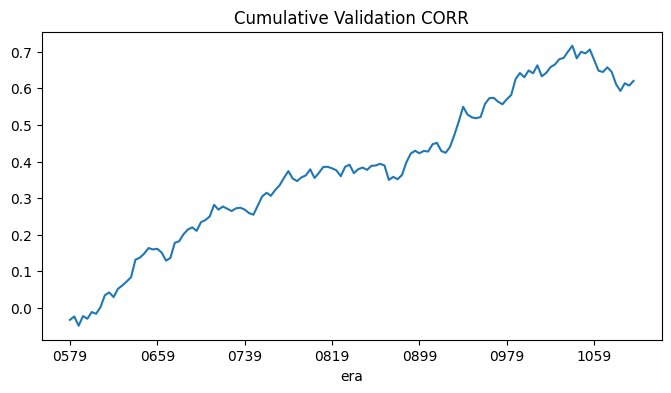

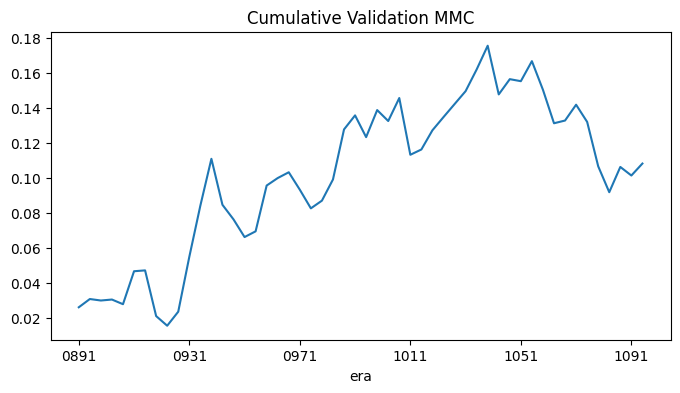

In [16]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

In [17]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

,CORR,MMC
mean,prediction 0.004773 dtype: float64,prediction 0.002078 dtype: float64
std,prediction 0.017365 dtype: float64,prediction 0.015334 dtype: float64
sharpe,prediction 0.274858 dtype: float64,prediction 0.135529 dtype: float64
max_drawdown,prediction 0.123622 dtype: float64,prediction 0.083647 dtype: float64


# Feature Neutralisation

<Axes: title={'center': 'Cumulative Absolute Value CORR of Features and the Target'}, xlabel='Era'>

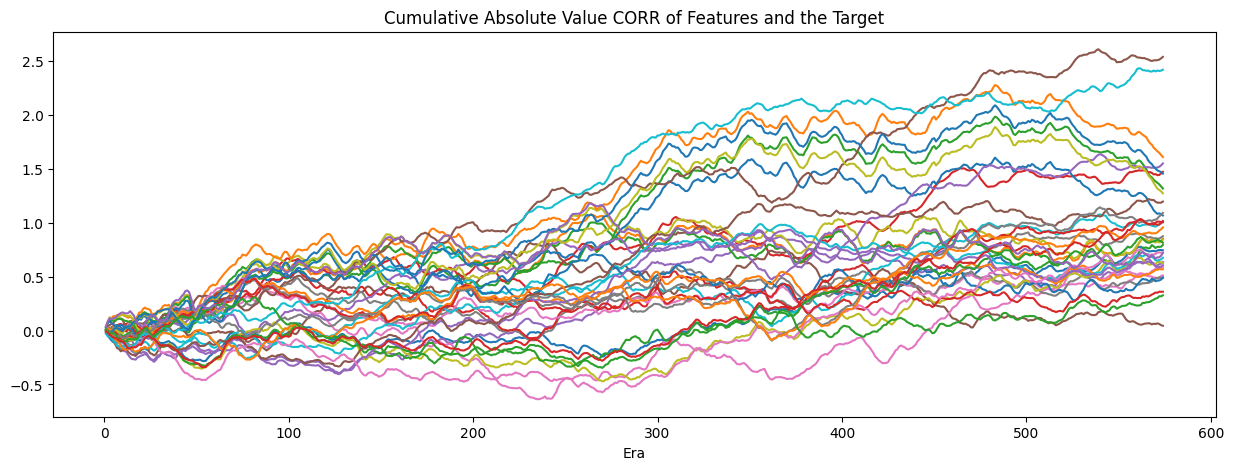

In [18]:
from numerai_tools.scoring import numerai_corr
import numpy as np

# Compute the per-era correlation of each serenity feature to the target
per_era_corr = train.groupby("era").apply(
    lambda d: numerai_corr(d[all_intelligence_feats], d["target"])
)

# Flip sign for negative mean correlation since we only care about magnitude
per_era_corr *= np.sign(per_era_corr.mean())

# Plot the per-era correlations
per_era_corr.cumsum().plot(
    title="Cumulative Absolute Value CORR of Features and the Target",
    figsize=(15, 5),
    legend=False,
    xlabel="Era"
  )